### This notebook contains the codes to generate all the plots used in the manuscript.
### Author: Chop Yan Lee

In [1]:
import pandas as pd
import numpy as np
from pymol import cmd
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
import scipy.stats as sp
import glob, os, json, pickle, sqlalchemy, db_utils
from sklearn.metrics import roc_curve, auc
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from statannotations.Annotator import Annotator
plt.rcParams['axes.spines.top'] = False # remove top spine
plt.rcParams['axes.spines.right'] = False # remove right spine
plt.rcParams['pdf.fonttype'] = 42 # Set the fonttype to export fonts as font files
plt.rcParams['font.family'] = 'Arial'
sns.set_palette("colorblind")
global_fontsize = 12
figsize = (3,3)
legend_fontsize = 8
bbox_to_anchor =(1, 1)
global_color = 'tab:grey'
connect = db_utils.get_connection()
save_path= '/Volumes/imb-luckgr/projects/dmi_predictor/DMI_AF2_PRS/Plots/DMI_types_minimal/AF2_MMv2.3/'

In [2]:
def modify_ticks_and_labels(ax,x_major_multiple=None,x_minor_multiple=None,
                            y_major_multiple=None,y_minor_multiple=None,change_markersize=False):
    global global_fontsize
    if x_major_multiple is not None:
        ax.tick_params(axis='x', which='both',labelsize=global_fontsize)
        ax.xaxis.set_major_locator(MultipleLocator(x_major_multiple))
        ax.xaxis.set_minor_locator(MultipleLocator(x_minor_multiple))
    if y_major_multiple is not None:
        ax.tick_params(axis='y', which='both',labelsize=global_fontsize)
        ax.yaxis.set_major_locator(MultipleLocator(y_major_multiple))
        ax.yaxis.set_minor_locator(MultipleLocator(y_minor_multiple))
    if change_markersize:
        plt.setp(ax.xaxis.get_majorticklines(), 'markersize', 5)
        plt.setp(ax.xaxis.get_majorticklines(), 'markeredgewidth', 2)
        plt.setp(ax.xaxis.get_minorticklines(), 'markersize', 3.5)
        plt.setp(ax.xaxis.get_minorticklines(), 'markeredgewidth', 2)
        plt.setp(ax.yaxis.get_majorticklines(), 'markersize', 5)
        plt.setp(ax.yaxis.get_majorticklines(), 'markeredgewidth', 2)
        plt.setp(ax.yaxis.get_minorticklines(), 'markersize', 3.5)
        plt.setp(ax.yaxis.get_minorticklines(), 'markeredgewidth', 2)
    plt.tick_params(axis= 'both', labelsize= global_fontsize)

In [3]:
def parse_prediction_name(prediction_name):
    """Parse out different components in the standard name for a minimal DMI prediction (e.g. run37_DEG_APCC_KENBOX_2_4GGD)

    Args:
        prediction_name (str): Name of the folder containing the AlphaFold predicted structure

    Returns:
        run_id (str): Run ID
        dmi_name (str): Name of DMI type
        pdb_id (str): PDB ID
    """
    splits = prediction_name.split('_')
    run_id = splits[0]
    dmi_name = '_'.join(splits[1:-1])
    pdb_id = splits[-1]
    return [run_id, dmi_name, pdb_id]

In [4]:
hydropathy_score = {'I':4.5, 'V':4.2, 'L':3.8, 'F':2.8, 'C':2.5, 'M':1.9, 'A':1.8, 'G':-0.4, 'T':-0.7,
                   'S':-0.8, 'W':-0.9, 'Y':-1.3, 'P':-1.6, 'H':-3.2, 'E':-3.5, 'Q':-3.5, 'D':-3.5,
                   'N':-3.5, 'K':-3.9, 'R':-4.5}

def calculate_symmetry_score(motif_seq):
    motif_length = len(motif_seq)
    symm_score = []
    global hydropathy_score
    for i, r in enumerate(motif_seq):
        if i < motif_length // 2:
            score_i = hydropathy_score[r]
            score_j = hydropathy_score[motif_seq[motif_length - (i + 1)]]
            symm_score.append(abs(score_i - score_j))
    return sum(symm_score) / (motif_length // 2)

In [5]:
elm_class = pd.read_csv('/Users/chopyanlee/Coding/Python/DMI/DMI_types_annotation/20221209_elm_classes.tsv',
                        sep='\t',header=5)
elm_class.rename({'ELMIdentifier':'dmi_name'},axis=1,inplace=True)
elm_class.head()

,Accession,dmi_name,FunctionalSiteName,Description,Regex,Probability,#Instances,#Instances_in_PDB
0,ELME000321,CLV_C14_Caspase3-7,Caspase cleavage motif,Caspase-3 and Caspase-7 cleavage site.,[DSTE][^P][^DEWHFYC]D[GSAN],0.003094,41,0
1,ELME000172,CLV_MEL_PAP_1,Melanisation activation site,Prophenoloxidase-activating proteinase (PAP) c...,[ILV]..R[VF][GS].,0.000105,12,0
2,ELME000102,CLV_NRD_NRD_1,NRD cleavage site,N-Arg dibasic convertase (NRD/Nardilysin) clea...,(.RK)|(RR[^KR]),0.007465,2,0
3,ELME000101,CLV_PCSK_FUR_1,PCSK cleavage site,Furin (PACE) cleavage site (R-X-[RK]-R-|-X).,R.[RK]R.,0.000509,13,0
4,ELME000108,CLV_PCSK_KEX2_1,PCSK cleavage site,Yeast kexin 2 cleavage site (K-R-|-X or R-R-|-X).,[KR]R.,0.007973,1,0


In [6]:
query = """select * from chopyan_db.AlphaFold_prediction_result
where run_id = 'run48' and project_name = 'AlphaFold_benchmark';"""
# read in processed info
run48 = pd.read_sql_query(query,con=connect)

run48[['run_id','dmi_name','pdb_id']] = run48.apply(lambda x: parse_prediction_name(x['prediction_name']),
                                                                        axis=1,result_type='expand')
print(run48.shape)

# I also only work with the best model as selected by the least RMSD_all_atom_peptide per predicton,
# the de-duplication will filter for best model per prediction
df = run48.sort_values(['RMSD_all_atom_peptide'],ascending=True).drop_duplicates(subset=['dmi_name','chainA_length',
                                                                           'chainB_length'],keep='first').copy()
df.reset_index(drop=True,inplace=True)
print(df.shape)

# merge for probability of elm_class information
df = pd.merge(df,elm_class[['dmi_name','Probability']],how='left')

# retrieve the annotated structure info from MySQL
query = """select dmi_type as dmi_name, methods from chopyan_db.AF2_DMI_structure_PRS
where for_AF2_benchmark = 1;"""
temp = pd.read_sql_query(query,con=connect)

# merge df with the annotated structure info
df = pd.merge(df,temp,how='left')

# structures solved by x-ray should be annotated because I would like to see if there is a bias in this factor
df['methods'] = np.where(df['methods'].str.contains('x-ray crystallography'), 'X-ray','Others')

# slice out ELM class
df['elm_class'] = df['dmi_name'].str.slice(stop=3)

# number of res-res contact should be normalized for peptide length
df['norm_num_res_res_contact'] = df['num_res_res_contact'] / df['chainB_length']

df

(680, 29)
(136, 29)


,project_name,prediction_name,run_id,chainA_length,chainB_length,model_id,model_confidence,chainA_intf_avg_plddt,chainB_intf_avg_plddt,intf_avg_plddt,...,DockQ,iRMS,LRMS,Fnonnat,dmi_name,pdb_id,Probability,methods,elm_class,norm_num_res_res_contact
0,AlphaFold_benchmark,run48_DOC_USP7_MATH_1_3MQS,run48,143,5,ranked_0,0.934844,98.136665,93.456000,96.759999,...,0.978,0.387,0.555,0.167,DOC_USP7_MATH_1,3MQS,1.238850e-02,X-ray,DOC,4.800000
1,AlphaFold_benchmark,run48_DEG_SPOP_SBC_1_3HQM,run48,137,5,ranked_4,0.922114,98.384000,93.250000,97.100500,...,0.969,0.327,0.844,0.037,DEG_SPOP_SBC_1,3HQM,9.379629e-04,X-ray,DEG,5.400000
2,AlphaFold_benchmark,run48_DEG_SIAH_1_2A25,run48,193,9,ranked_3,0.931102,96.314286,93.671111,95.521334,...,0.961,0.472,0.442,0.114,DEG_SIAH_1,2A25,2.714819e-05,X-ray,DEG,4.888889
3,AlphaFold_benchmark,run48_DOC_PP2B_PxIxI_1_4F0Z,run48,292,7,ranked_2,0.958944,98.275625,94.781430,97.212174,...,0.958,0.393,0.450,0.000,DOC_PP2B_PxIxI_1,4F0Z,1.367857e-04,X-ray,DOC,4.571429
4,AlphaFold_benchmark,run48_DOC_ANK_TNKS_1_3TWU,run48,160,8,ranked_0,0.934079,98.609412,94.977499,97.447200,...,0.979,0.372,0.620,0.083,DOC_ANK_TNKS_1,3TWU,3.537886e-04,X-ray,DOC,4.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131,AlphaFold_benchmark,run48_LIG_CNOT1_NIM_1_4CQO,run48,437,10,ranked_1,0.605383,76.222778,34.572500,63.407308,...,0.108,6.612,13.782,1.000,LIG_CNOT1_NIM_1,4CQO,5.437492e-08,X-ray,LIG,3.700000
132,AlphaFold_benchmark,run48_LIG_Clathr_ClatBox_2_1UTC,run48,328,6,ranked_4,0.558989,90.894762,25.531667,76.369630,...,0.038,8.174,28.367,1.000,LIG_Clathr_ClatBox_2,1UTC,1.462831e-06,X-ray,LIG,6.166667
133,AlphaFold_benchmark,run48_LIG_GLEBS_BUB3_1_2I3S,run48,340,9,ranked_2,0.620200,89.311764,32.368750,71.089999,...,0.034,9.002,29.853,1.000,LIG_GLEBS_BUB3_1,2I3S,9.069110e-07,X-ray,LIG,3.888889
134,AlphaFold_benchmark,run48_DOC_PP1_MyPhoNE_1_1S70,run48,299,8,ranked_0,0.664014,92.738235,39.720000,75.772400,...,0.021,12.909,36.725,1.000,DOC_PP1_MyPhoNE_1,1S70,4.405197e-07,X-ray,DOC,5.000000


In [7]:
# set up the RMSD peptide classification and DockQ classification
condlist = [df['RMSD_all_atom_peptide'] <= 2,
            (df['RMSD_all_atom_peptide'] > 2) & (df['RMSD_all_atom_peptide'] <= 5),
            (df['RMSD_all_atom_peptide'] > 5) & (df['RMSD_all_atom_peptide'] <= 15),
            df['RMSD_all_atom_peptide'] > 15]
choicelist = ['correct_sidechain','correct_backbone','correct_pocket','wrong_pocket']
df['RMSD_all_atom_peptide_classification'] = np.select(condlist,choicelist)

condlist = [df['DockQ'] < 0.23,
            (df['DockQ'] >= 0.23) & (df['DockQ'] < 0.49),
            (df['DockQ'] >= 0.49) & (df['DockQ'] < 0.8),
            df['DockQ'] >= 0.8]
choicelist = ['Incorrect','Acceptable','Medium','High']
df['DockQ_classification'] = np.select(condlist,choicelist)
df

,project_name,prediction_name,run_id,chainA_length,chainB_length,model_id,model_confidence,chainA_intf_avg_plddt,chainB_intf_avg_plddt,intf_avg_plddt,...,LRMS,Fnonnat,dmi_name,pdb_id,Probability,methods,elm_class,norm_num_res_res_contact,RMSD_all_atom_peptide_classification,DockQ_classification
0,AlphaFold_benchmark,run48_DOC_USP7_MATH_1_3MQS,run48,143,5,ranked_0,0.934844,98.136665,93.456000,96.759999,...,0.555,0.167,DOC_USP7_MATH_1,3MQS,1.238850e-02,X-ray,DOC,4.800000,correct_sidechain,High
1,AlphaFold_benchmark,run48_DEG_SPOP_SBC_1_3HQM,run48,137,5,ranked_4,0.922114,98.384000,93.250000,97.100500,...,0.844,0.037,DEG_SPOP_SBC_1,3HQM,9.379629e-04,X-ray,DEG,5.400000,correct_sidechain,High
2,AlphaFold_benchmark,run48_DEG_SIAH_1_2A25,run48,193,9,ranked_3,0.931102,96.314286,93.671111,95.521334,...,0.442,0.114,DEG_SIAH_1,2A25,2.714819e-05,X-ray,DEG,4.888889,correct_sidechain,High
3,AlphaFold_benchmark,run48_DOC_PP2B_PxIxI_1_4F0Z,run48,292,7,ranked_2,0.958944,98.275625,94.781430,97.212174,...,0.450,0.000,DOC_PP2B_PxIxI_1,4F0Z,1.367857e-04,X-ray,DOC,4.571429,correct_sidechain,High
4,AlphaFold_benchmark,run48_DOC_ANK_TNKS_1_3TWU,run48,160,8,ranked_0,0.934079,98.609412,94.977499,97.447200,...,0.620,0.083,DOC_ANK_TNKS_1,3TWU,3.537886e-04,X-ray,DOC,4.500000,correct_sidechain,High
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131,AlphaFold_benchmark,run48_LIG_CNOT1_NIM_1_4CQO,run48,437,10,ranked_1,0.605383,76.222778,34.572500,63.407308,...,13.782,1.000,LIG_CNOT1_NIM_1,4CQO,5.437492e-08,X-ray,LIG,3.700000,correct_pocket,Incorrect
132,AlphaFold_benchmark,run48_LIG_Clathr_ClatBox_2_1UTC,run48,328,6,ranked_4,0.558989,90.894762,25.531667,76.369630,...,28.367,1.000,LIG_Clathr_ClatBox_2,1UTC,1.462831e-06,X-ray,LIG,6.166667,wrong_pocket,Incorrect
133,AlphaFold_benchmark,run48_LIG_GLEBS_BUB3_1_2I3S,run48,340,9,ranked_2,0.620200,89.311764,32.368750,71.089999,...,29.853,1.000,LIG_GLEBS_BUB3_1,2I3S,9.069110e-07,X-ray,LIG,3.888889,wrong_pocket,Incorrect
134,AlphaFold_benchmark,run48_DOC_PP1_MyPhoNE_1_1S70,run48,299,8,ranked_0,0.664014,92.738235,39.720000,75.772400,...,36.725,1.000,DOC_PP1_MyPhoNE_1,1S70,4.405197e-07,X-ray,DOC,5.000000,wrong_pocket,Incorrect


In [8]:
# include motif sequence info because it will be needed to calculate hydropathy score and symmetry score
motif_seq = {}
root_path = '/Volumes/imb-luckgr/projects/dmi_predictor/DMI_AF2_PRS/run48/'
for pred in df['prediction_name'].to_list():
    with open(os.path.join(root_path,f"{pred}.fasta"),'r') as f:
        lines= [line.strip() for line in f.readlines()]
        for i, line in enumerate(lines[1:]):
            if line[0] == '>':
                motif_sequence = lines[i+2]
        motif_seq[pred] = motif_sequence

df['motif_sequence'] = [motif_seq[pred_name] for pred_name in df['prediction_name']]
df['average_hydropathy_score'] = [sum([hydropathy_score[resi] for resi in seq])/len(seq) for seq in df['motif_sequence']]
df['peptide_symmetry_score'] = df.apply(lambda x: calculate_symmetry_score(x['motif_sequence']), axis=1)
df.head()

,project_name,prediction_name,run_id,chainA_length,chainB_length,model_id,model_confidence,chainA_intf_avg_plddt,chainB_intf_avg_plddt,intf_avg_plddt,...,pdb_id,Probability,methods,elm_class,norm_num_res_res_contact,RMSD_all_atom_peptide_classification,DockQ_classification,motif_sequence,average_hydropathy_score,peptide_symmetry_score
0,AlphaFold_benchmark,run48_DOC_USP7_MATH_1_3MQS,run48,143,5,ranked_0,0.934844,98.136665,93.456000,96.759999,...,3MQS,0.012388,X-ray,DOC,4.800000,correct_sidechain,High,PSTSS,-0.940000,0.40
1,AlphaFold_benchmark,run48_DEG_SPOP_SBC_1_3HQM,run48,137,5,ranked_4,0.922114,98.384000,93.250000,97.100500,...,3HQM,0.000938,X-ray,DEG,5.400000,correct_sidechain,High,VSSST,0.220000,2.45
2,AlphaFold_benchmark,run48_DEG_SIAH_1_2A25,run48,193,9,ranked_3,0.931102,96.314286,93.671111,95.521334,...,2A25,0.000027,X-ray,DEG,4.888889,correct_sidechain,High,KPAAVVAPI,1.244444,2.70
3,AlphaFold_benchmark,run48_DOC_PP2B_PxIxI_1_4F0Z,run48,292,7,ranked_2,0.958944,98.275625,94.781430,97.212174,...,4F0Z,0.000137,X-ray,DOC,4.571429,correct_sidechain,High,KPKIIIT,0.485714,5.90
4,AlphaFold_benchmark,run48_DOC_ANK_TNKS_1_3TWU,run48,160,8,ranked_0,0.934079,98.609412,94.977499,97.447200,...,3TWU,0.000354,X-ray,DOC,4.500000,correct_sidechain,High,ARPPPIGA,-0.200000,2.55


In [9]:
# include secondary structure information of the predicted motif
df['predicted_motif_SS'] = np.nan
for i, r in df.iterrows():
    path = '/Volumes/imb-luckgr/projects/dmi_predictor/DMI_AF2_PRS/'
    run_id = r['run_id']
    model_id = r['model_id']
    prediction_name = r['prediction_name']
    SS_set = set()
    cmd.load(f'{path}{run_id}/{prediction_name}/{model_id}.pdb')
    cmd.iterate('chain B and n. CA', 'SS_set.add(ss)', space={'SS_set':SS_set})
    cmd.reinitialize()
    df.loc[i,'predicted_motif_SS'] = ','.join(SS_set)
conditions = [(df['predicted_motif_SS'].str.contains('H')),
             (df['predicted_motif_SS'].str.contains('S'))]
values = ['H','S']
df['predicted_motif_SS_short'] = np.select(conditions,values,default='L')
df.head()

,project_name,prediction_name,run_id,chainA_length,chainB_length,model_id,model_confidence,chainA_intf_avg_plddt,chainB_intf_avg_plddt,intf_avg_plddt,...,methods,elm_class,norm_num_res_res_contact,RMSD_all_atom_peptide_classification,DockQ_classification,motif_sequence,average_hydropathy_score,peptide_symmetry_score,predicted_motif_SS,predicted_motif_SS_short
0,AlphaFold_benchmark,run48_DOC_USP7_MATH_1_3MQS,run48,143,5,ranked_0,0.934844,98.136665,93.456000,96.759999,...,X-ray,DOC,4.800000,correct_sidechain,High,PSTSS,-0.940000,0.40,L,L
1,AlphaFold_benchmark,run48_DEG_SPOP_SBC_1_3HQM,run48,137,5,ranked_4,0.922114,98.384000,93.250000,97.100500,...,X-ray,DEG,5.400000,correct_sidechain,High,VSSST,0.220000,2.45,L,L
2,AlphaFold_benchmark,run48_DEG_SIAH_1_2A25,run48,193,9,ranked_3,0.931102,96.314286,93.671111,95.521334,...,X-ray,DEG,4.888889,correct_sidechain,High,KPAAVVAPI,1.244444,2.70,"S,L",S
3,AlphaFold_benchmark,run48_DOC_PP2B_PxIxI_1_4F0Z,run48,292,7,ranked_2,0.958944,98.275625,94.781430,97.212174,...,X-ray,DOC,4.571429,correct_sidechain,High,KPKIIIT,0.485714,5.90,"S,L",S
4,AlphaFold_benchmark,run48_DOC_ANK_TNKS_1_3TWU,run48,160,8,ranked_0,0.934079,98.609412,94.977499,97.447200,...,X-ray,DOC,4.500000,correct_sidechain,High,ARPPPIGA,-0.200000,2.55,L,L


In [10]:
# include secondary structure information of the solved motif
annot_DMI = pd.read_csv('/Volumes/imb-luckgr/projects/dmi_predictor/DMI_AF2_PRS/AF2_DMI_structure_PRS - Sheet1.tsv',
                       sep='\t')
annot_DMI = annot_DMI[annot_DMI['for_AF2_benchmark'] == 1][['dmi_type','motif_secondary_structure']].copy()

df = pd.merge(df,annot_DMI.rename({'dmi_type':'dmi_name'},axis=1)).rename({'motif_secondary_structure':'solved_motif_secondary_structure'},
                                                                         axis=1)
df.head()

,project_name,prediction_name,run_id,chainA_length,chainB_length,model_id,model_confidence,chainA_intf_avg_plddt,chainB_intf_avg_plddt,intf_avg_plddt,...,elm_class,norm_num_res_res_contact,RMSD_all_atom_peptide_classification,DockQ_classification,motif_sequence,average_hydropathy_score,peptide_symmetry_score,predicted_motif_SS,predicted_motif_SS_short,solved_motif_secondary_structure
0,AlphaFold_benchmark,run48_DOC_USP7_MATH_1_3MQS,run48,143,5,ranked_0,0.934844,98.136665,93.456000,96.759999,...,DOC,4.800000,correct_sidechain,High,PSTSS,-0.940000,0.40,L,L,L
1,AlphaFold_benchmark,run48_DEG_SPOP_SBC_1_3HQM,run48,137,5,ranked_4,0.922114,98.384000,93.250000,97.100500,...,DEG,5.400000,correct_sidechain,High,VSSST,0.220000,2.45,L,L,L
2,AlphaFold_benchmark,run48_DEG_SIAH_1_2A25,run48,193,9,ranked_3,0.931102,96.314286,93.671111,95.521334,...,DEG,4.888889,correct_sidechain,High,KPAAVVAPI,1.244444,2.70,"S,L",S,S
3,AlphaFold_benchmark,run48_DOC_PP2B_PxIxI_1_4F0Z,run48,292,7,ranked_2,0.958944,98.275625,94.781430,97.212174,...,DOC,4.571429,correct_sidechain,High,KPKIIIT,0.485714,5.90,"S,L",S,S
4,AlphaFold_benchmark,run48_DOC_ANK_TNKS_1_3TWU,run48,160,8,ranked_0,0.934079,98.609412,94.977499,97.447200,...,DOC,4.500000,correct_sidechain,High,ARPPPIGA,-0.200000,2.55,L,L,L


Check the correlation between all atom peptide RMSD and DockQ to show the validity of using all atom peptide RMSD as a proxy to prediction accuracy

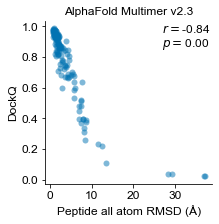

In [11]:
# plot a scatterplot of the two metrics' correlation
cor = sp.pearsonr(df['RMSD_all_atom_peptide'],df['DockQ'])

fig,ax = plt.subplots(figsize=figsize)
plt.scatter(df['RMSD_all_atom_peptide'], df['DockQ'], alpha=0.5,linewidths=0)

modify_ticks_and_labels(ax, x_major_multiple=10, x_minor_multiple=10, y_major_multiple=0.2, y_minor_multiple=0.2)
plt.setp(ax.xaxis.get_ticklines(), 'visible', True)
ax.tick_params(top=False)
plt.ylabel('DockQ', fontsize=global_fontsize)
plt.xlabel('Peptide all atom RMSD (Å)', fontsize=global_fontsize)
plt.text(0.7,0.84,transform=plt.gca().transAxes,s=r'$r = $' + f'{cor[0]:.2f}' + '\n' + r'$p = $' + f'{cor[1]:.2f}',
         fontsize=global_fontsize)
ax.set_title('AlphaFold Multimer v2.3',fontsize=global_fontsize)

plt.savefig(f'{save_path}DockQ_all_atom_peptide_RMSD_scatterplot.pdf',
           transparent=True,bbox_inches='tight')
plt.savefig(f'{save_path}DockQ_all_atom_peptide_RMSD_scatterplot.jpeg',dpi=300,
           transparent=True,bbox_inches='tight')
plt.show()

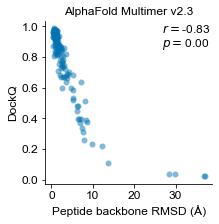

In [12]:
# plot a scatterplot of the two metrics' correlation
cor = sp.pearsonr(df['RMSD_backbone_peptide'],df['DockQ'])

fig,ax = plt.subplots(figsize=figsize)
plt.scatter(df['RMSD_backbone_peptide'], df['DockQ'], alpha=0.5,linewidths=0)

modify_ticks_and_labels(ax, x_major_multiple=10, x_minor_multiple=10, y_major_multiple=0.2, y_minor_multiple=0.2)
plt.setp(ax.xaxis.get_ticklines(), 'visible', True)
ax.tick_params(top=False)
plt.ylabel('DockQ', fontsize=global_fontsize)
plt.xlabel('Peptide backbone RMSD (Å)', fontsize=global_fontsize)
plt.text(0.7,0.84,transform=plt.gca().transAxes,s=r'$r = $' + f'{cor[0]:.2f}' + '\n' + r'$p = $' + f'{cor[1]:.2f}',
         fontsize=global_fontsize)
ax.set_title('AlphaFold Multimer v2.3',fontsize=global_fontsize)

plt.savefig(f'{save_path}DockQ_backbone_peptide_RMSD_scatterplot.pdf',
           transparent=True,bbox_inches='tight')
plt.savefig(f'{save_path}DockQ_backbone_peptide_RMSD_scatterplot.jpeg',dpi=300,
           transparent=True,bbox_inches='tight')
plt.show()

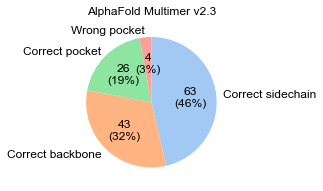

In [13]:
# plot the RMSD peptide classification in a piechart to see the proportion of different classes
temp = df.groupby('RMSD_all_atom_peptide_classification').size()

data_dict = {index:values for index,values in zip(temp.index,temp.values)}

class_order = ['correct_sidechain','correct_backbone','correct_pocket','wrong_pocket']

#define Seaborn color palette to use
colors = sns.color_palette('pastel')[:len(temp.index)]

#create pie chart
fig, ax = plt.subplots(figsize=figsize)

ax.pie([data_dict[value] for value in class_order],
        labels=['Correct sidechain','Correct backbone','Correct pocket','Wrong pocket'],
        colors=colors,autopct=lambda x: f'{int((x*sum(data_dict.values())/100.0)+0.5)}\n({x:.0f}%)',
        textprops={'fontsize': global_fontsize},counterclock=False,startangle=90)
ax.set_title('AlphaFold Multimer v2.3',fontsize=global_fontsize)

plt.savefig(f'{save_path}proportion_RMSD_all_atom_peptide_classification_piechart.pdf',
           bbox_inches='tight',transparent=True)
plt.savefig(f'{save_path}proportion_RMSD_all_atom_peptide_classification_piechart.jpeg',dpi=300,
           bbox_inches='tight',transparent=True)
plt.show()

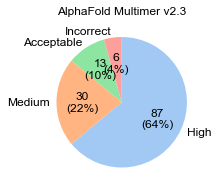

In [14]:
# same with DockQ
temp = df.groupby('DockQ_classification').size()

data_dict = {index:values for index,values in zip(temp.index,temp.values)}

class_order = ['High','Medium','Acceptable','Incorrect']

#define Seaborn color palette to use
colors = sns.color_palette('pastel')[:len(temp.index)]

#create pie chart
fig, ax = plt.subplots(figsize=figsize)

ax.pie([data_dict[value] for value in class_order],
        labels=class_order,
        colors=colors,autopct=lambda x: f'{int((x*sum(data_dict.values())/100.0)+0.5)}\n({x:.0f}%)',
        textprops={'fontsize': global_fontsize},counterclock=False,startangle=90)
ax.set_title('AlphaFold Multimer v2.3',fontsize=global_fontsize)

plt.savefig(f'{save_path}proportion_DockQ_classification_piechart.pdf',
           bbox_inches='tight',transparent=True)
plt.savefig(f'{save_path}proportion_DockQ_piechart.jpeg',dpi=300,
           bbox_inches='tight',transparent=True)
plt.show()

Check if there is any prediction accuracy bias towards any ELM class

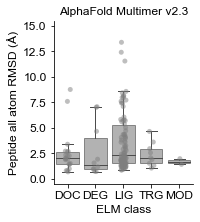

In [15]:
fig, ax = plt.subplots(figsize=(2.5,3))

sns.boxplot(data=df,x='elm_class',y='RMSD_all_atom_peptide',showfliers=False,linewidth=1,boxprops={'alpha':0.6},
            ax=ax,color=global_color)
sns.stripplot(data=df,x='elm_class',y='RMSD_all_atom_peptide',dodge=True,alpha=0.5,ax=ax,color=global_color)

plt.ylim([-0.5,15.5]) # limit the y axis so that the box plot can be seen better 
plt.ylabel('Peptide all atom RMSD (Å)', fontsize=global_fontsize)
plt.xlabel('ELM class', fontsize=global_fontsize)
ax.set_title('AlphaFold Multimer v2.3',fontsize=global_fontsize)
modify_ticks_and_labels(ax,y_major_multiple=2.5,y_minor_multiple=2.5,x_major_multiple=1,x_minor_multiple=1)

plt.savefig(f'{save_path}all_atom_peptide_RMSD_elm_class.pdf',transparent=True,bbox_inches='tight')
plt.savefig(f'{save_path}all_atom_peptide_RMSD_elm_class.jpeg',transparent=True,bbox_inches='tight',dpi=300)
plt.show()

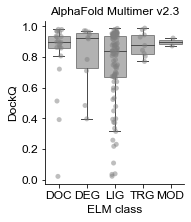

In [16]:
fig, ax = plt.subplots(figsize=(2.5,3))

sns.boxplot(data=df,x='elm_class',y='DockQ',showfliers=False,linewidth=1,boxprops={'alpha':0.6},
            ax=ax,color=global_color)
sns.stripplot(data=df,x='elm_class',y='DockQ',dodge=True,alpha=0.5,ax=ax,color=global_color)

plt.ylabel('DockQ', fontsize=global_fontsize)
plt.xlabel('ELM class', fontsize=global_fontsize)
ax.set_title('AlphaFold Multimer v2.3',fontsize=global_fontsize)
modify_ticks_and_labels(ax,y_major_multiple=0.2,y_minor_multiple=0.2,x_major_multiple=1,x_minor_multiple=1)

plt.savefig(f'{save_path}DockQ_elm_class.pdf',transparent=True,bbox_inches='tight')
plt.savefig(f'{save_path}DockQ_elm_class.jpeg',transparent=True,bbox_inches='tight',dpi=300)
plt.show()

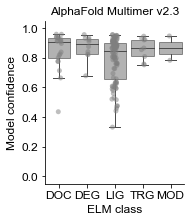

In [17]:
fig, ax = plt.subplots(figsize=(2.5,3))

sns.boxplot(data=df,x='elm_class',y='model_confidence',showfliers=False,linewidth=1,boxprops={'alpha':0.6},
            ax=ax,color=global_color)
sns.stripplot(data=df,x='elm_class',y='model_confidence',dodge=True,alpha=0.5,ax=ax,color=global_color)

plt.ylim([-0.05,1.05])
plt.ylabel('Model confidence', fontsize=global_fontsize)
plt.xlabel('ELM class', fontsize=global_fontsize)
ax.set_title('AlphaFold Multimer v2.3',fontsize=global_fontsize)
modify_ticks_and_labels(ax,y_major_multiple=0.2,y_minor_multiple=0.2,x_major_multiple=1,x_minor_multiple=1)

plt.savefig(f'{save_path}model_confidence_elm_class.pdf',transparent=True,bbox_inches='tight')
plt.savefig(f'{save_path}model_confidence_elm_class.jpeg',transparent=True,bbox_inches='tight',dpi=300)
plt.show()

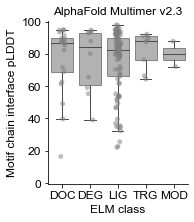

In [18]:
fig, ax = plt.subplots(figsize=(2.5,3))

sns.boxplot(data=df,x='elm_class',y='chainB_intf_avg_plddt',showfliers=False,linewidth=1,boxprops={'alpha':0.6},
            ax=ax,color=global_color)
sns.stripplot(data=df,x='elm_class',y='chainB_intf_avg_plddt',dodge=True,alpha=0.5,ax=ax,color=global_color)

plt.ylim([-0.5,100.5])
plt.ylabel('Motif chain interface pLDDT', fontsize=global_fontsize)
plt.xlabel('ELM class', fontsize=global_fontsize)
ax.set_title('AlphaFold Multimer v2.3',fontsize=global_fontsize)
modify_ticks_and_labels(ax,y_major_multiple=20,y_minor_multiple=20,x_major_multiple=1,x_minor_multiple=1)

plt.savefig(f'{save_path}motif_chain_interface_plddt_elm_class.pdf',transparent=True,bbox_inches='tight')
plt.savefig(f'{save_path}motif_chain_interface_plddt_elm_class.jpeg',transparent=True,bbox_inches='tight',dpi=300)
plt.show()

Look into the different factors that can affect prediction accuracy

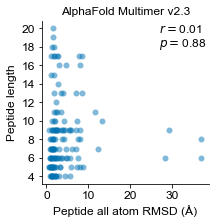

In [19]:
cor = sp.pearsonr(df['chainB_length'],df['RMSD_all_atom_peptide'])

fig,ax = plt.subplots(figsize=figsize)

plt.scatter(df['RMSD_all_atom_peptide'], df['chainB_length'], alpha=0.5,linewidths=0)
modify_ticks_and_labels(ax, y_major_multiple=2, y_minor_multiple=2, x_major_multiple=10, x_minor_multiple=10)
plt.setp(ax.xaxis.get_ticklines(), 'visible', True)
ax.tick_params(top=False)
plt.xlabel('Peptide all atom RMSD (Å)', fontsize=global_fontsize)
plt.ylabel('Peptide length', fontsize=global_fontsize)

plt.text(0.7,0.84,transform=plt.gca().transAxes,s=r'$r = $' + f'{cor[0]:.2f}' + '\n' + r'$p = $' + f'{cor[1]:.2f}',
         fontsize=global_fontsize)
ax.set_title('AlphaFold Multimer v2.3',fontsize=global_fontsize)

plt.savefig(f'{save_path}RMSD_all_atom_peptide_peptide_length_scatterplot.pdf',
           transparent=True,bbox_inches='tight')
plt.savefig(f'{save_path}RMSD_all_atom_peptide_peptide_length_scatterplot.jpeg',dpi=300,
           transparent=True,bbox_inches='tight')
plt.show()

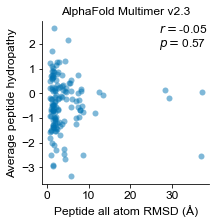

In [20]:
cor = sp.pearsonr(df['RMSD_all_atom_peptide'],df['average_hydropathy_score'])

fig,ax = plt.subplots(figsize=figsize)

plt.scatter(df['RMSD_all_atom_peptide'], df['average_hydropathy_score'], alpha=0.5,linewidths=0)
modify_ticks_and_labels(ax, y_major_multiple=1, y_minor_multiple=1, x_major_multiple=10, x_minor_multiple=10)
plt.setp(ax.xaxis.get_ticklines(), 'visible', True)
ax.tick_params(top=False)
plt.xlabel('Peptide all atom RMSD (Å)', fontsize=global_fontsize)
plt.ylabel('Average peptide hydropathy', fontsize=global_fontsize)

plt.text(0.7,0.84,transform=plt.gca().transAxes,s=r'$r = $' + f'{cor[0]:.2f}' + '\n' + r'$p = $' + f'{cor[1]:.2f}',
         fontsize=global_fontsize)
ax.set_title('AlphaFold Multimer v2.3',fontsize=global_fontsize)

plt.savefig(f'{save_path}hydropathy_RMSD_all_atom_peptide_scatterplot.pdf',
           transparent=True,bbox_inches='tight')
plt.savefig(f'{save_path}hydropathy_RMSD_all_atom_peptide_scatterplot.jpeg',dpi=300,
           transparent=True,bbox_inches='tight')
plt.show()

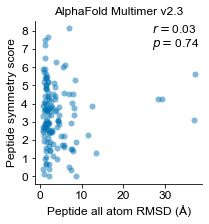

In [21]:
cor = sp.pearsonr(df['RMSD_all_atom_peptide'],df['peptide_symmetry_score'])

fig,ax = plt.subplots(figsize=figsize)

plt.scatter(df['RMSD_all_atom_peptide'],df['peptide_symmetry_score'], alpha=0.5,linewidths=0)
modify_ticks_and_labels(ax, y_major_multiple=1, y_minor_multiple=1, x_major_multiple=10, x_minor_multiple=10)
plt.setp(ax.xaxis.get_ticklines(), 'visible', True)
ax.tick_params(top=False)
plt.xlabel('Peptide all atom RMSD (Å)', fontsize=global_fontsize)
plt.ylabel('Peptide symmetry score', fontsize=global_fontsize)

plt.text(0.7,0.84,transform=plt.gca().transAxes,s=r'$r = $' + f'{cor[0]:.2f}' + '\n' + r'$p = $' + f'{cor[1]:.2f}',
         fontsize=global_fontsize)
ax.set_title('AlphaFold Multimer v2.3',fontsize=global_fontsize)

plt.savefig(f'{save_path}symmetry_score_RMSD_all_atom_peptide_scatterplot.pdf',
           transparent=True,bbox_inches='tight')
plt.savefig(f'{save_path}symmetry_score_RMSD_all_atom_peptide_scatterplot.jpeg',dpi=300,
           transparent=True,bbox_inches='tight')
plt.show()

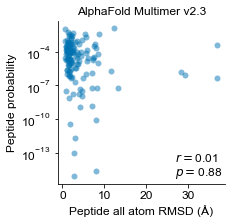

In [22]:
cor = sp.pearsonr(df['RMSD_all_atom_peptide'],df['Probability'])

fig,ax = plt.subplots(figsize=figsize)

plt.scatter(df['RMSD_all_atom_peptide'], df['Probability'], alpha=0.5,linewidths=0)
modify_ticks_and_labels(ax,x_major_multiple=10, x_minor_multiple=10)
plt.setp(ax.xaxis.get_ticklines(), 'visible', True)
ax.tick_params(top=False)
plt.yscale('log')
plt.xlabel('Peptide all atom RMSD (Å)', fontsize=global_fontsize)
plt.ylabel('Peptide probability', fontsize=global_fontsize)

plt.text(0.70,0.05,transform=plt.gca().transAxes,s=r'$r = $' + f'{cor[0]:.2f}' + '\n' + r'$p = $' + f'{cor[1]:.2f}',
         fontsize=global_fontsize)
ax.set_title('AlphaFold Multimer v2.3',fontsize=global_fontsize)

plt.savefig(f'{save_path}peptide_probability_RMSD_all_atom_peptide_scatterplot.pdf',
           transparent=True,bbox_inches='tight')
plt.savefig(f'{save_path}peptide_probability_RMSD_all_atom_peptide_scatterplot.jpeg',dpi=300,
           transparent=True,bbox_inches='tight')
plt.show()

Is there a bias in prediction performance towards peptide of certain secondary structure?

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

H vs. S: Mann-Whitney-Wilcoxon test two-sided, P_val:5.659e-01 U_stat=1.680e+02
S vs. L: Mann-Whitney-Wilcoxon test two-sided, P_val:9.103e-01 U_stat=2.960e+02
H vs. L: Mann-Whitney-Wilcoxon test two-sided, P_val:1.402e-01 U_stat=2.121e+03


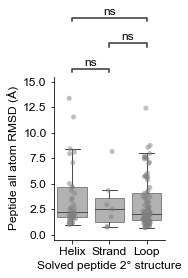

In [23]:
xlabel_dict = {'L':'Loop','H':'Helix','S':'Strand'}

fig, ax = plt.subplots(figsize=(2,3))

sns.boxplot(data=df,x='solved_motif_secondary_structure',y='RMSD_all_atom_peptide',showfliers=False,linewidth=1,
            boxprops={'alpha':0.6},ax=ax,order=['H','S','L'],color=global_color)
sns.stripplot(data=df,x='solved_motif_secondary_structure',y='RMSD_all_atom_peptide',dodge=True,alpha=0.5,ax=ax,
             order=['H','S','L'],color=global_color)
plt.ylim([-0.5,15.5]) # limit the y axis so that the box plot can be seen better

annotator = Annotator(ax, pairs=[('H','S'),('H','L'),('S','L')],data=df, x='solved_motif_secondary_structure',
                      y='RMSD_all_atom_peptide', order=['H','S','L'])
annotator.configure(test='Mann-Whitney', text_format='star', loc='outside',line_offset=5,
                    **{'fontsize':global_fontsize})
annotator.apply_and_annotate()

plt.ylabel('Peptide all atom RMSD (Å)', fontsize=global_fontsize)
plt.xlabel('Solved peptide 2° structure',fontsize=global_fontsize)
plt.xticks(ax.get_xticks(),[xlabel_dict.get(label.get_text()) for label in ax.get_xticklabels()])
modify_ticks_and_labels(ax,y_major_multiple=2.5,y_minor_multiple=2.5,x_major_multiple=1,x_minor_multiple=1)
# plt.title('AlphaFold Multimer v2.3',fontsize=global_fontsize,pad=40)

plt.savefig(f'{save_path}RMSD_all_atom_peptide_solved_peptide_2nd_structure.pdf',transparent=True,
            bbox_inches='tight')
plt.savefig(f'{save_path}RMSD_all_atom_peptide_solved_peptide_2nd_structure.jpeg',transparent=True,dpi=300,
            bbox_inches='tight')
plt.show()

Does AlphaFold metrics show bias towards any secondary structure prediction? e.g. giving higher metrics to helically predicted peptide

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

H vs. S: Mann-Whitney-Wilcoxon test two-sided, P_val:6.428e-01 U_stat=2.560e+02
S vs. L: Mann-Whitney-Wilcoxon test two-sided, P_val:4.457e-02 U_stat=7.680e+02
H vs. L: Mann-Whitney-Wilcoxon test two-sided, P_val:6.647e-02 U_stat=1.977e+03


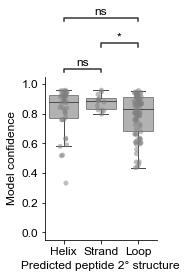

In [24]:
xlabel_dict = {'L':'Loop','H':'Helix','S':'Strand'}

fig, ax = plt.subplots(figsize=(2,3))
sns.boxplot(data=df,x='predicted_motif_SS_short',y='model_confidence',showfliers=False,linewidth=1,
            boxprops={'alpha':0.6},ax=ax,order=['H','S','L'],color=global_color)
sns.stripplot(data=df,x='predicted_motif_SS_short',y='model_confidence',dodge=True,alpha=0.5,ax=ax,
             order=['H','S','L'],color=global_color)
plt.ylim([-0.05,1.05])

annotator = Annotator(ax, pairs=[('H','S'),('H','L'),('S','L')],data=df, x='predicted_motif_SS_short',
                      y='model_confidence', order=['H','S','L'])
annotator.configure(test='Mann-Whitney', text_format='star', loc='outside',line_offset=5,
                    **{'fontsize':global_fontsize})
annotator.apply_and_annotate()

plt.ylabel('Model confidence', fontsize=global_fontsize)
plt.xlabel('Predicted peptide 2° structure',fontsize=global_fontsize)
plt.xticks(ax.get_xticks(),[xlabel_dict.get(label.get_text()) for label in ax.get_xticklabels()])
modify_ticks_and_labels(ax,y_major_multiple=0.2,y_minor_multiple=0.2,x_major_multiple=1,x_minor_multiple=1)

plt.savefig(f'{save_path}model_confidence_predicted_peptide_2nd_structure.pdf',transparent=True,bbox_inches='tight')
plt.savefig(f'{save_path}model_confidence_predicted_peptide_2nd_structure.jpeg',transparent=True,
            bbox_inches='tight',dpi=300)
plt.show()

How about the way the structure of the PRS is solved?

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

X-ray vs. Others: Mann-Whitney-Wilcoxon test two-sided, P_val:3.610e-02 U_stat=8.590e+02


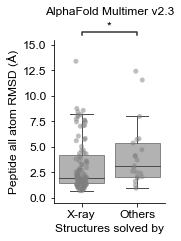

In [25]:
order=['X-ray','Others']
fig, ax = plt.subplots(figsize=(2,3))

sns.boxplot(data=df,x='methods',y='RMSD_all_atom_peptide',showfliers=False,linewidth=1,
            boxprops={'alpha':0.6},ax=ax,order=order,color=global_color)
sns.stripplot(data=df,x='methods',y='RMSD_all_atom_peptide',dodge=True,alpha=0.5,ax=ax,
             order=order,color=global_color)
plt.ylim([-0.5,15.5]) # limit the y axis so that the box plot can be seen better

annotator = Annotator(ax, pairs=[('X-ray','Others')],data=df, x='methods',
                      y='RMSD_all_atom_peptide', order=order)
annotator.configure(test='Mann-Whitney', text_format='star', loc='outside',line_offset=5,
                    **{'fontsize':global_fontsize})
annotator.apply_and_annotate()

plt.ylabel('Peptide all atom RMSD (Å)', fontsize=global_fontsize)
plt.xlabel('Structures solved by',fontsize=global_fontsize)
modify_ticks_and_labels(ax,y_major_multiple=2.5,y_minor_multiple=2.5,x_major_multiple=1,x_minor_multiple=1)
plt.title('AlphaFold Multimer v2.3',fontsize=global_fontsize,pad=25)

plt.savefig(f'{save_path}RMSD_all_atom_peptide_X-ray.pdf',transparent=True,bbox_inches='tight')
plt.savefig(f'{save_path}RMSD_all_atom_peptide_X-ray.jpeg',transparent=True,bbox_inches='tight',dpi=300)
plt.show()

The prediction performance of X-ray solved and non X-ray solved structure differ significantly, but does AlphaFold metrics reflect this?

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

X-ray vs. Others: Mann-Whitney-Wilcoxon test two-sided, P_val:7.764e-02 U_stat=1.501e+03


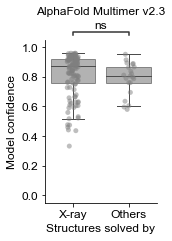

In [26]:
order=['X-ray','Others']
fig, ax = plt.subplots(figsize=(2,3))

sns.boxplot(data=df,x='methods',y='model_confidence',showfliers=False,linewidth=1,
            boxprops={'alpha':0.6},ax=ax,order=order,color=global_color)
sns.stripplot(data=df,x='methods',y='model_confidence',dodge=True,alpha=0.5,ax=ax,
             order=order,color=global_color)
plt.ylim([-0.05,1.05])

annotator = Annotator(ax, pairs=[('X-ray','Others')],data=df, x='methods',
                      y='model_confidence', order=order)
annotator.configure(test='Mann-Whitney', text_format='star', loc='outside',line_offset=5,
                    **{'fontsize':global_fontsize})
annotator.apply_and_annotate()

plt.ylabel('Model confidence', fontsize=global_fontsize)
plt.xlabel('Structures solved by',fontsize=global_fontsize)
modify_ticks_and_labels(ax,y_major_multiple=0.2,y_minor_multiple=0.2,x_major_multiple=1,x_minor_multiple=1)
plt.title('AlphaFold Multimer v2.3',fontsize=global_fontsize,pad=25)

plt.savefig(f'{save_path}model_confidence_X-ray.pdf',transparent=True,bbox_inches='tight')
plt.savefig(f'{save_path}model_confidence_X-ray.jpeg',transparent=True,bbox_inches='tight',dpi=300)
plt.show()

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

X-ray vs. Others: Mann-Whitney-Wilcoxon test two-sided, P_val:7.269e-01 U_stat=1.149e+03


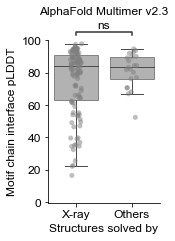

In [27]:
order=['X-ray','Others']
fig, ax = plt.subplots(figsize=(2,3))

sns.boxplot(data=df,x='methods',y='chainB_intf_avg_plddt',showfliers=False,linewidth=1,
            boxprops={'alpha':0.6},ax=ax,order=order,color=global_color)
sns.stripplot(data=df,x='methods',y='chainB_intf_avg_plddt',dodge=True,alpha=0.5,ax=ax,
             order=order,color=global_color)
plt.ylim([-0.5,100.5])

annotator = Annotator(ax, pairs=[('X-ray','Others')],data=df, x='methods',
                      y='chainB_intf_avg_plddt', order=order)
annotator.configure(test='Mann-Whitney', text_format='star', loc='outside',line_offset=5,
                    **{'fontsize':global_fontsize})
annotator.apply_and_annotate()

plt.ylabel('Motif chain interface pLDDT', fontsize=global_fontsize)
plt.xlabel('Structures solved by',fontsize=global_fontsize)
modify_ticks_and_labels(ax,y_major_multiple=20,y_minor_multiple=20,x_major_multiple=1,x_minor_multiple=1)
plt.title('AlphaFold Multimer v2.3',fontsize=global_fontsize,pad=25)

plt.savefig(f'{save_path}motif_chain_interface_plddt_X-ray.pdf',transparent=True,bbox_inches='tight')
plt.savefig(f'{save_path}motif_chain_interface_plddt_X-ray.jpeg',transparent=True,bbox_inches='tight',dpi=300)
plt.show()

Are AlphaFold metrics predictive of prediction accuracy (as measured by peptide all atom RMSD or DockQ)?

Model confidence

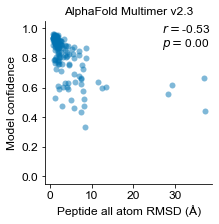

In [28]:
cor = sp.pearsonr(df['RMSD_all_atom_peptide'],df['model_confidence'])
fig,ax = plt.subplots(figsize=figsize)

plt.scatter(df['RMSD_all_atom_peptide'],df['model_confidence'], alpha=0.5,linewidths=0)
modify_ticks_and_labels(ax, x_major_multiple=10, x_minor_multiple=10, y_major_multiple=0.2, y_minor_multiple=0.2)
plt.ylabel('Model confidence', fontsize=global_fontsize)
plt.xlabel('Peptide all atom RMSD (Å)', fontsize=global_fontsize)
plt.ylim([-0.05,1.05])

plt.text(0.7,0.84,transform=plt.gca().transAxes,s=r'$r = $' + f'{cor[0]:.2f}' + '\n' + r'$p = $' + f'{cor[1]:.2f}',
         fontsize=global_fontsize)
ax.set_title('AlphaFold Multimer v2.3',fontsize=global_fontsize)

plt.savefig(f'{save_path}model_confidence_RMSD_all_atom_peptide_scatterplot.pdf',
           transparent=True,bbox_inches='tight')
plt.savefig(f'{save_path}model_confidence_RMSD_all_atom_peptide_scatterplot.jpeg',dpi=300,
           transparent=True,bbox_inches='tight')
plt.show()

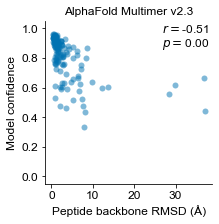

In [29]:
cor = sp.pearsonr(df['RMSD_backbone_peptide'],df['model_confidence'])
fig,ax = plt.subplots(figsize=figsize)

plt.scatter(df['RMSD_backbone_peptide'],df['model_confidence'], alpha=0.5,linewidths=0)
modify_ticks_and_labels(ax, x_major_multiple=10, x_minor_multiple=10, y_major_multiple=0.2, y_minor_multiple=0.2)
plt.ylabel('Model confidence', fontsize=global_fontsize)
plt.xlabel('Peptide backbone RMSD (Å)', fontsize=global_fontsize)
plt.ylim([-0.05,1.05])

plt.text(0.7,0.84,transform=plt.gca().transAxes,s=r'$r = $' + f'{cor[0]:.2f}' + '\n' + r'$p = $' + f'{cor[1]:.2f}',
         fontsize=global_fontsize)
ax.set_title('AlphaFold Multimer v2.3',fontsize=global_fontsize)

plt.savefig(f'{save_path}model_confidence_RMSD_backbone_peptide_scatterplot.pdf',
           transparent=True,bbox_inches='tight')
plt.savefig(f'{save_path}model_confidence_RMSD_backbone_peptide_scatterplot.jpeg',dpi=300,
           transparent=True,bbox_inches='tight')
plt.show()

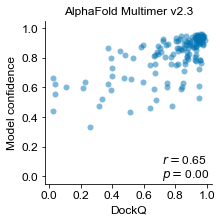

In [30]:
cor = sp.pearsonr(df['DockQ'],df['model_confidence'])
fig,ax = plt.subplots(figsize=figsize)

plt.scatter(df['DockQ'],df['model_confidence'], alpha=0.5,linewidths=0)
modify_ticks_and_labels(ax, x_major_multiple=0.2, x_minor_multiple=0.2, y_major_multiple=0.2, y_minor_multiple=0.2)
plt.ylabel('Model confidence', fontsize=global_fontsize)
plt.xlabel('DockQ', fontsize=global_fontsize)
plt.ylim([-0.05,1.05])

plt.text(0.7,0.04,transform=plt.gca().transAxes,s=r'$r = $' + f'{cor[0]:.2f}' + '\n' + r'$p = $' + f'{cor[1]:.2f}',
         fontsize=global_fontsize)
ax.set_title('AlphaFold Multimer v2.3',fontsize=global_fontsize)

plt.savefig(f'{save_path}model_confidence_DockQ_scatterplot.pdf',
           transparent=True,bbox_inches='tight')
plt.savefig(f'{save_path}model_confidence_DockQ_scatterplot.jpeg',dpi=300,
           transparent=True,bbox_inches='tight')

plt.show()

Motif chain interface pLDDT

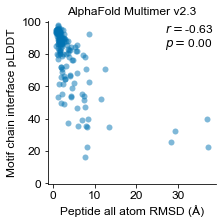

In [31]:
temp = df[df['chainB_intf_avg_plddt'].notna()].copy()
cor = sp.pearsonr(temp['RMSD_all_atom_peptide'],temp['chainB_intf_avg_plddt'])
fig,ax = plt.subplots(figsize=figsize)

plt.scatter(temp['RMSD_all_atom_peptide'],temp['chainB_intf_avg_plddt'], alpha=0.5,linewidths=0)
modify_ticks_and_labels(ax, x_major_multiple=10, x_minor_multiple=10, y_major_multiple=20, y_minor_multiple=20)
plt.ylabel('Motif chain interface pLDDT', fontsize=global_fontsize)
plt.xlabel('Peptide all atom RMSD (Å)', fontsize=global_fontsize)
plt.ylim([-0.5,100.5]) # excluded one point with avg_intf_plddt =0

plt.text(0.7,0.84,transform=plt.gca().transAxes,s=r'$r = $' + f'{cor[0]:.2f}' + '\n' + r'$p = $' + f'{cor[1]:.2f}',
         fontsize=global_fontsize)
ax.set_title('AlphaFold Multimer v2.3',fontsize=global_fontsize)

plt.savefig(f'{save_path}motif_chain_interface_plddt_RMSD_all_atom_peptide_scatterplot.pdf',
           transparent=True,bbox_inches='tight')
plt.savefig(f'{save_path}motif_chain_interface_plddt_RMSD_all_atom_peptide_scatterplot.pdf',dpi=300,
           transparent=True,bbox_inches='tight')
plt.show()

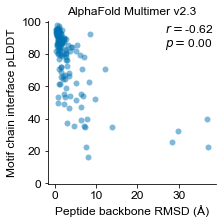

In [32]:
temp = df[df['chainB_intf_avg_plddt'].notna()].copy()
cor = sp.pearsonr(temp['RMSD_backbone_peptide'],temp['chainB_intf_avg_plddt'])
fig,ax = plt.subplots(figsize=figsize)

plt.scatter(temp['RMSD_backbone_peptide'],temp['chainB_intf_avg_plddt'], alpha=0.5,linewidths=0)
modify_ticks_and_labels(ax, x_major_multiple=10, x_minor_multiple=10, y_major_multiple=20, y_minor_multiple=20)
plt.ylabel('Motif chain interface pLDDT', fontsize=global_fontsize)
plt.xlabel('Peptide backbone RMSD (Å)', fontsize=global_fontsize)
plt.ylim([-0.5,100.5]) # excluded one point with avg_intf_plddt =0

plt.text(0.7,0.84,transform=plt.gca().transAxes,s=r'$r = $' + f'{cor[0]:.2f}' + '\n' + r'$p = $' + f'{cor[1]:.2f}',
         fontsize=global_fontsize)
ax.set_title('AlphaFold Multimer v2.3',fontsize=global_fontsize)

plt.savefig(f'{save_path}motif_chain_interface_plddt_RMSD_backbone_peptide_scatterplot.pdf',
           transparent=True,bbox_inches='tight')
plt.savefig(f'{save_path}motif_chain_interface_plddt_RMSD_backbone_peptide_scatterplot.jpeg',dpi=300,
           transparent=True,bbox_inches='tight')
plt.show()

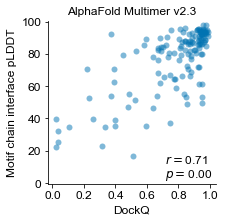

In [33]:
temp = df[df['chainB_intf_avg_plddt'].notna()].copy()
cor = sp.pearsonr(temp['DockQ'],temp['chainB_intf_avg_plddt'])
fig,ax = plt.subplots(figsize=figsize)

plt.scatter(temp['DockQ'],temp['chainB_intf_avg_plddt'], alpha=0.5,linewidths=0)
modify_ticks_and_labels(ax, x_major_multiple=0.2, x_minor_multiple=0.2, y_major_multiple=20, y_minor_multiple=20)
plt.ylabel('Motif chain interface pLDDT', fontsize=global_fontsize)
plt.xlabel('DockQ', fontsize=global_fontsize)
plt.ylim([-0.5,100.5]) # excluded one point with avg_intf_plddt =0

plt.text(0.7,0.04,transform=plt.gca().transAxes,s=r'$r = $' + f'{cor[0]:.2f}' + '\n' + r'$p = $' + f'{cor[1]:.2f}',
         fontsize=global_fontsize)
ax.set_title('AlphaFold Multimer v2.3',fontsize=global_fontsize)

plt.savefig(f'{save_path}motif_chain_interface_plddt_DockQ_scatterplot.pdf',
           transparent=True,bbox_inches='tight')
plt.savefig(f'{save_path}motif_chain_interface_plddt_DockQ_scatterplot.jpeg',dpi=300,
           transparent=True,bbox_inches='tight')
plt.show()

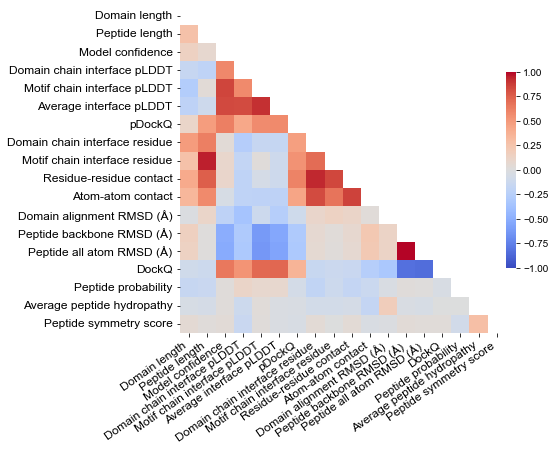

In [36]:
better_name = {'chainA_length':'Domain length',
               'chainB_length':'Peptide length',
               'model_confidence':'Model confidence',
               'chainA_intf_avg_plddt':'Domain chain interface pLDDT',
               'chainB_intf_avg_plddt':'Motif chain interface pLDDT',
               'intf_avg_plddt':'Average interface pLDDT',
               'pDockQ':'pDockQ',
               'num_chainA_intf_res':'Domain chain interface residue',
               'num_chainB_intf_res':'Motif chain interface residue',
               'num_res_res_contact':'Residue-residue contact',
               'num_atom_atom_contact':'Atom-atom contact',
               'RMSD_domain':'Domain alignment RMSD (Å)',
               'RMSD_backbone_peptide':'Peptide backbone RMSD (Å)',
               'RMSD_all_atom_peptide':'Peptide all atom RMSD (Å)',
               'DockQ':'DockQ',
               'Probability':'Peptide probability',
               'average_hydropathy_score':'Average peptide hydropathy',
               'peptide_symmetry_score':'Peptide symmetry score'
              }

temp = df[list(better_name)].copy()
corr = temp.corr()
mask = np.triu(corr)

fig, ax = plt.subplots(figsize=(9,6))

sns.heatmap(data=corr,mask=mask,square=True,cmap='coolwarm',vmin=-1,vmax=1,xticklabels=1,yticklabels=1,ax=ax,
           cbar_kws={'shrink':0.6,'pad':0.001})
ax.set_xticklabels([better_name.get(tick.get_text()) for tick in ax.get_xticklabels()],fontsize=global_fontsize,
                  rotation=35,ha='right')
ax.set_yticklabels([better_name.get(tick.get_text()) for tick in ax.get_yticklabels()],fontsize=global_fontsize)

plt.savefig(f'{save_path}correlation_heatmap.pdf',
           transparent=True,bbox_inches='tight')
plt.savefig(f'{save_path}correlation_heatmap.jpeg',dpi=300,
           transparent=True,bbox_inches='tight')
plt.show()

----
Export data for publication

In [37]:
temp = df.copy()
temp['prediction_name'] = [pred_name.lstrip(f'{run_id}_') for pred_name, run_id in zip(temp['prediction_name'],
                                                                                temp['run_id'])]
temp.to_csv('/Volumes/imb-luckgr/manuscripts/AlphaFold_paper/tables/MMv2.3_minimal_DMI_prediction_raw.tsv',
         sep='\t',index=None)